# Diabetes
by Kenan Sooklall

Diabetes is a chronic (long-lasting) health condition that affects how your body turns food into energy.

Most of the food you eat is broken down into sugar (also called glucose) and released into your bloodstream. When your blood sugar goes up, it signals your pancreas to release insulin. Insulin acts like a key to let the blood sugar into your body’s cells for use as energy.

Source: [Centers for Disease Control and Preventation](https://www.cdc.gov/diabetes/basics/diabetes.html)

In [1]:
import pandas as pd
import numpy as np

import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

import shap
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.preprocessing import StandardScaler, normalize, LabelEncoder, MinMaxScaler
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.model_selection import train_test_split, cross_validate, cross_val_score, GridSearchCV
%matplotlib inline

Dropping
- A lot of missing values
    - weight 
    - payer code
    - medical_specialty
- Only one value
    - examide, citoglipton have 
- Conflict
    - race
- Duplicated patient_nbr

In [2]:
#df = pd.read_csv('abhishek_diabetes.csv', index_col=[0]).query('Diabetes_012 != "1"').rename(columns={'Diabetes_012': 'label'})
#df['label'] = df['label'].map({0: 0, 2: 1})
drop_cols = ['examide', 'citoglipton', 'encounter_id','weight', 'payer_code', 'medical_specialty', 'race', 'glimepiride-pioglitazone']
df = pd.read_csv('dataset_diabetes/diabetic_data.csv').drop(drop_cols, axis=1).\
            replace('?', np.nan).\
            drop_duplicates(subset=['patient_nbr']).\
            drop(['patient_nbr'], axis=1)
df['readmitted'] = df['readmitted'].map({'NO': 0, '>30': 1, '<30': 1})

In [3]:
young = 'young'
middle = 'adult'
old = 'old'

age_mapping = {'[0-10)': young, '[10-20)': young, '[20-30)': young, '[30-40)': middle, '[40-50)': middle, '[50-60)': middle,
         '[60-70)': old, '[70-80)': old, '[80-90)': old, '[90-100)': old}
df['age_mapped'] = df['age'].map(age_mapping)

In [4]:
drug_cols = ['metformin', 'repaglinide', 'nateglinide', 'chlorpropamide',
             'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
             'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
             'tolazamide', 'insulin', 'glyburide-metformin', 'glipizide-metformin', 
             'metformin-rosiglitazone', 'metformin-pioglitazone']
diag_cols = ['Circulatory', 'Diabetes', 'Digestive', 'Genitourinary', 'Injury', 
             'Muscoloskeletal', 'Neoplasms', 'Other', 'Respiratory']

In [5]:
print(df.shape)
df.head()

(71518, 42)


,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,...,tolazamide,insulin,glyburide-metformin,glipizide-metformin,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted,age_mapped
0,Female,[0-10),6,25,1,1,41,0,1,0,...,No,No,No,No,No,No,No,No,0,young
1,Female,[10-20),1,1,7,3,59,0,18,0,...,No,Up,No,No,No,No,Ch,Yes,1,young
2,Female,[20-30),1,1,7,2,11,5,13,2,...,No,No,No,No,No,No,No,Yes,0,young
3,Male,[30-40),1,1,7,2,44,1,16,0,...,No,Up,No,No,No,No,Ch,Yes,0,adult
4,Male,[40-50),1,1,7,1,51,0,8,0,...,No,Steady,No,No,No,No,Ch,Yes,0,adult


difference between high blood sugar >200 and very high blood sugar >300
   - how certain medication doses goes up

In [6]:
def glu_plots(df, target):
    fig, axs = plt.subplots(5, 4, figsize = (15, 10))
    for idx, i in enumerate(axs.flatten()):
        drug = drug_cols[idx]
        sns.countplot(data=df[drug_cols + [target]], x=drug, hue=target, ax=i)#.set(title=drug)
        i.set_yticks([0, 500,1000,1500])
        
        if idx != 3:
            i.legend([],[], frameon=False)
        else:
            i.legend(title=target, loc='upper right')
    
    plt.tight_layout()

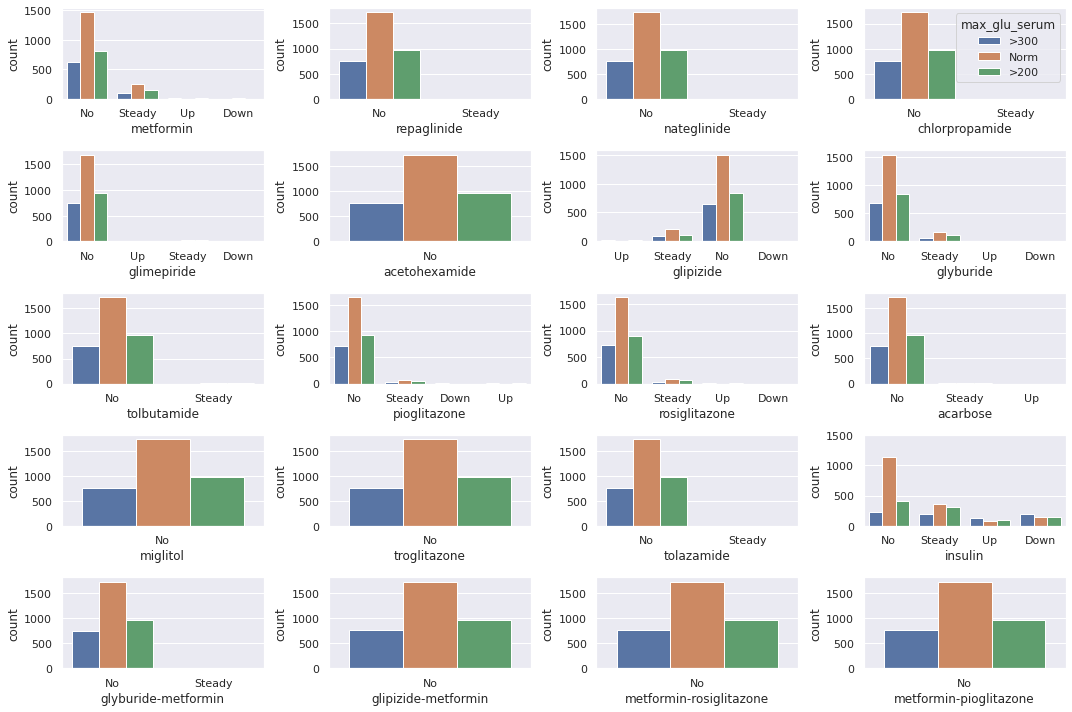

In [7]:
glu_plots(df[df['max_glu_serum'].ne('None')].reset_index(drop=True), target='max_glu_serum')

   - number of changes

In [8]:
df.columns

Index(['gender', 'age', 'admission_type_id', 'discharge_disposition_id',
       'admission_source_id', 'time_in_hospital', 'num_lab_procedures',
       'num_procedures', 'num_medications', 'number_outpatient',
       'number_emergency', 'number_inpatient', 'diag_1', 'diag_2', 'diag_3',
       'number_diagnoses', 'max_glu_serum', 'A1Cresult', 'metformin',
       'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride',
       'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
       'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
       'tolazamide', 'insulin', 'glyburide-metformin', 'glipizide-metformin',
       'metformin-rosiglitazone', 'metformin-pioglitazone', 'change',
       'diabetesMed', 'readmitted', 'age_mapped'],
      dtype='object')

The data set contains 22 columns and 253680 rows
- Encounter ID: Unique identifier of an encounter
- Patient number: Unique identifier of a patient
- Race Values: Caucasian, Asian, African American, Hispanic, and other
- Gender Values: male, female, and unknown/invalid
- Age: Grouped in 10-year intervals - 0, 10), 10, 20), …, 90, 100)
- Weight: Weight in pounds
- Admission type: Integer identifier corresponding to 9 distinct values, for example, emergency, urgent, elective, newborn, and not available
- Discharge disposition: Integer identifier corresponding to 29 distinct values, for example, discharged to home, expired, and not available
- Admission source: Integer identifier corresponding to 21 distinct values, for example, physician referral, emergency room, and transfer from a hospital
- Time in hospital: Integer number of days between admission and discharge
- Payer code: Integer identifier corresponding to 23 distinct values, for example, Blue Cross/Blue Shield, Medicare, and self-pay Medical
- Medical specialty: Integer identifier of a specialty of the admitting physician, corresponding to 84 distinct values, for example, cardiology, internal medicine, family/general practice, and surgeon
- Number of lab: procedures Number of lab tests performed during the encounter
- Number of procedures: Numeric Number of procedures (other than lab tests) performed during the encounter
- Number of medications: Number of distinct generic names administered during the encounter
- Number of outpatient: visits Number of outpatient visits of the patient in the year preceding the encounter
- Number of emergency: visits Number of emergency visits of the patient in the year preceding the encounter
- Number of inpatient: visits Number of inpatient visits of the patient in the year preceding the encounter
- Diagnosis 1: The primary diagnosis (coded as first three digits of ICD9); 848 distinct values
- Diagnosis 2: Secondary diagnosis (coded as first three digits of ICD9); 923 distinct values
- Diagnosis 3: Additional secondary diagnosis (coded as first three digits of ICD9); 954 distinct values
- Number of diagnoses: Number of diagnoses entered to the system 0%
- Glucose serum test: result Indicates the range of the result or if the test was not taken. Values: “>200,” “>300,” “normal,” and “none” if not measured
- A1c test result: Indicates the range of the result or if the test was not taken. Values - '>8' if the result was greater than 8%, “>7” if the result was greater than 7% but less than 8%, “normal” if the result was less than 7%, and “none” if not measured. 7% to 8% is an increase of ~30mg/dl of glucose, 6%=120mg/dl
- Change of medications: Indicates if there was a change in diabetic medications (either dosage or generic name). Values - 'change' and 'no change'
- Diabetes medications: Indicates if there was any diabetic medication prescribed. Values: 'yes' and 'no'
- 24 features for medications: glyburide-metformin, glipizide-metformin, glimepiride-pioglitazone, metformin-rosiglitazone, and metformin-pioglitazone, the feature indicates whether the drug was prescribed or there was a change in the dosage. Values - 'up' if the dosage was increased during the encounter, 'down' if the dosage was decreased, 'steady' if the dosage did not change, and 'no' if the drug was not prescribed
- Readmitted Days: Values '<30' if the patient was readmitted in less than 30 days, '>30' if the patient was readmitted in more than 30 days, and 'No' for no record of readmission

source: https://archive-beta.ics.uci.edu/ml/datasets/diabetes+130+us+hospitals+for+years+1999+2008

###  Exploratory Data Analysis

Very lucky to find a dataset with no missing values and no duplicated rows

we can see the data are all on very different scales, which is to be expected. An initial point of concern is  SkinThichkness of 0mm, however that could be more of a percision issue. Another column of concern is BMI, BloodPressure and Glucose, it can't be 0. The min age being greater than 0 is expected and all other values look normal

In [9]:
metrics = ['mean', 'median', 'std']
df.groupby(['readmitted']).agg({"number_diagnoses": metrics,
                            "num_medications": metrics,
                               'num_procedures': metrics,
                               'time_in_hospital': metrics
                               })

number_diagnoses                  num_medications                   \
                       mean median       std            mean median       std   
readmitted                                                                      
0                  7.082238      8  2.058517       15.473816     14  8.565825   
1                  7.491957      8  1.867654       16.053342     15  7.899434   

           num_procedures                  time_in_hospital                   
                     mean median       std             mean median       std  
readmitted                                                                    
0                1.470769      1  1.773368         4.147214      3  2.910694  
1                1.370028      1  1.737599         4.502926      4  2.993679

<AxesSubplot:xlabel='readmitted', ylabel='count'>

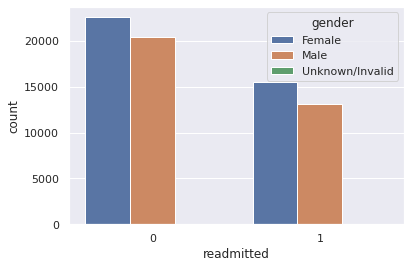

In [10]:
sns.countplot(x='readmitted', data=df, hue='gender')

gender seems to be mostly independant if someone will be remitted

In [ ]:
plt.figure(figsize=(14, 8))
sns.countplot(x='readmitted', data=df, hue='age_mapped')
#plt.savefig('age.jpg')

The older portion of the population is the majority for all ranges of readmitted

In [ ]:
df[['age_mapped', 'A1Cresult', 'readmitted']].query('A1Cresult != "None"').sample(50).to_csv('sample_df.csv', index=False)

In [ ]:
plt.figure(figsize=(14, 8))
sns.barplot(x='readmitted', data=df[df['A1Cresult'].ne('None')], hue='age_mapped')

In [ ]:
df[['max_glu_serum', 'A1Cresult']]

In [ ]:
#plt.figure(figsize=(10, 8))
sns.countplot(x='readmitted', data=df[df['max_glu_serum'].ne(0)], hue='max_glu_serum', hue_order=['>300', '>200', 1])
#plt.savefig('graphs/max_glucose_serum.jpg')

In [ ]:
sns.countplot(x='readmitted', data=df[df['A1Cresult'].ne(0)], hue='A1Cresult', hue_order=['>8', '>7', 1])
#plt.savefig('graphs/A1Cresults.jpg')

In [ ]:
df[df['readmitted'].eq(0)]['A1Cresult'].value_counts(normalize=True)

## Feature extractor

Quantify categorical data

quantify variables
- age - take the median values
- readmitted - 0: NO 1: other

In [11]:
df = df.replace(['No','NO', 'None', 'Steady', 'Up', 'Down', 'Yes', 'Ch', 'Norm'], [0,0,0,1,1,1,1,1,1])
df['age'] = df['age'].map(lambda x: sum([int(i) for i in x[1:-1].split('-')]) // 2)
df['max_glu_serum_num'] = df['max_glu_serum'].map({0: 0, 1: 1, '>200': 1, '>300': 1}).astype(int)
df['A1Cresult_num'] = df['A1Cresult'].map({0: 0, 1: 1, '>8': 1, '>7': 1}).astype(int)
df['gender'] = df['gender'].map({'Male': 0, 'Female': 1})
df = df.dropna(subset=['gender'])

Map ids

In [12]:
def map_diagnosis(df, cols):    
    for i in cols:
        df[i] = pd.to_numeric(df[i], errors='coerce')
    
    for col in cols:
        df["diag"] = 'Other'
        df.loc[df[col].between(459, 785) | df[col].eq(785), "diag"] = "Circulatory"
        df.loc[df[col].between(460, 519) | df[col].eq(786), "diag"] = "Respiratory"
        df.loc[df[col].between(520, 579) | df[col].eq(787), "diag"] = "Digestive"
        df.loc[df[col].between(250, 251), "diag"] = "Diabetes"
        df.loc[df[col].between(800, 999), "diag"] = "Injury"
        df.loc[df[col].between(710, 739), "diag"] = "Muscoloskeletal"
        df.loc[df[col].between(580, 629) | df[col].eq(788), "diag"] = "Genitourinary"
        neoplasms_codes = df[col].between(140, 249) | df[col].between(251, 279) | df[col].isin([780,781,784]) | df[col].between(790, 799)
        df.loc[neoplasms_codes, "diag"] = "Neoplasms"
        df[col] = df["diag"]
        df = df.drop("diag", axis=1)

    return df

In [13]:
df = map_diagnosis(df, ["diag_1","diag_2","diag_3"])

In [14]:
df['readmitted'].value_counts(normalize=True)

0    0.601021
1    0.398979
Name: readmitted, dtype: float64

In [15]:
df['time_in_hospital'].value_counts(normalize=True)

3     0.177599
2     0.173348
1     0.149829
4     0.133776
5     0.095630
6     0.072307
7     0.055918
8     0.040803
9     0.027826
10    0.021786
11    0.017353
12    0.013354
13    0.011117
14    0.009355
Name: time_in_hospital, dtype: float64

Get dummies for diag columns

In [16]:
diag = pd.get_dummies(df['diag_1']) + pd.get_dummies(df['diag_2']) + pd.get_dummies(df['diag_3'])
df = pd.concat([df.drop(df.filter(like='diag_').columns, axis=1), diag], axis=1)

In [17]:
df = pd.concat([df.drop(['age_mapped'], axis=1), pd.get_dummies(df['age_mapped'])], axis=1)

<AxesSubplot:ylabel='readmitted'>

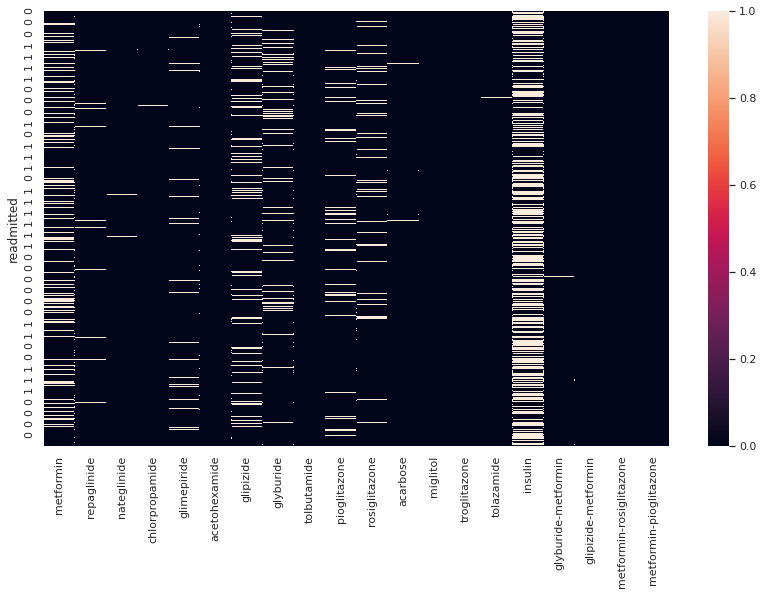

In [18]:
plt.figure(figsize=(14, 8))
sns.heatmap(df[drug_cols + ['readmitted']].set_index('readmitted'))

In [19]:
df.head()

,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,...,Digestive,Genitourinary,Injury,Muscoloskeletal,Neoplasms,Other,Respiratory,adult,old,young
0,1.0,5,6,25,1,1,41,0,1,0,...,0,0,0,0,0,2,0,0,0,1
1,1.0,15,1,1,7,3,59,0,18,0,...,0,0,0,0,2,0,0,0,0,1
2,1.0,25,1,1,7,2,11,5,13,2,...,0,0,0,0,0,1,0,0,0,1
3,0.0,35,1,1,7,2,44,1,16,0,...,0,0,0,0,0,2,0,1,0,0
4,0.0,45,1,1,7,1,51,0,8,0,...,0,0,0,0,2,0,0,1,0,0


In [ ]:
sns.countplot(data=df[['tolazamide'] + ['readmitted']], x='tolazamide', hue='readmitted')

In [ ]:
fig, axs = plt.subplots(5, 4, figsize = (15, 10))
for idx, i in enumerate(axs.flatten()):
    drug = drug_cols[idx]
    sns.countplot(data=df[drug_cols + ['readmitted']], x=drug, hue='readmitted', ax=i)#.set(title=drug)
    i.set_yticks([0, 1e4,2e4,3e4,4e4])

    if idx != 3:
        i.legend([],[], frameon=False)
    else:
        i.legend(title="Readmitted", loc='upper right')

plt.tight_layout()
#plt.savefig('drug.jpg')

In [ ]:
df[df.columns[~df.columns.isin(drug_cols + diag_cols)]].head()

In [ ]:
df['A1Cresult'].value_counts()

Closer look at A1C results and Glucose serum test

In [ ]:
df[df['A1Cresult'].ne(0) & df['max_glu_serum'].ne(0)][glucose_tests + ['readmitted']].

In [ ]:
a1c_df = pd.get_dummies(df[df['A1Cresult'].ne(0)]['A1Cresult']).merge(df[['readmitted']], left_index=True, right_index=True).rename(columns={1: 'normal'}).reset_index(drop=True)
glu_df = pd.get_dummies(df[df['max_glu_serum'].ne(0)]['max_glu_serum']).merge(df[['readmitted']], left_index=True, right_index=True).rename(columns={1: 'normal'}).reset_index(drop=True)
a1c_glu_df = pd.concat([a1c_df, glu_df.drop('readmitted', axis=1)], axis=1).dropna()

In [ ]:
a1c_glu_df['readmitted'].value_counts(normalize=True)

In [ ]:
sns.countplot(x='readmitted', data=df[df['A1Cresult'].ne(0)], hue='A1Cresult')

In [ ]:
sns.countplot(x='readmitted', data=df[df['max_glu_serum'].ne(0)], hue='max_glu_serum')

time in hospital
 - staying longer lead to high readmittion

In [ ]:
df[['time_in_hospital', 'readmitted']].groupby('readmitted')['time_in_hospital'].sum()

Dropped for mostly 0s
 - number_inpatient
 - number_emergency
 - number_outpatient
 - max_glu_serum
 - A1Cresult

In [ ]:
df['readmitted'].value_counts(normalize=True)

# Modeling

In [20]:
features = ['gender', 'old', 'young', 'adult', 'time_in_hospital', 'num_lab_procedures', 
            'num_procedures', 'num_medications', 'number_diagnoses', 'diabetesMed']
glucose_tests = ['max_glu_serum_num', 'A1Cresult_num']
num_cols = ['time_in_hospital','num_lab_procedures', 'num_medications','number_diagnoses']
model_features = features+glucose_tests+num_cols

### Logistic Regression
This is a classification problem so LogisticRegression  is a good starting model

In [21]:
seed = 42
diab_df = df[model_features + ['readmitted']]
#diab_df = a1c_glu_df

In [ ]:
scaler = StandardScaler()
diab_df.loc[:, num_cols] = scaler.fit_transform(diab_df[num_cols])

In [22]:
norm = MinMaxScaler()
diab_df.loc[:, num_cols] = norm.fit_transform(diab_df[num_cols])


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [23]:
diab_df.head()

,gender,old,young,adult,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_diagnoses,diabetesMed,max_glu_serum_num,A1Cresult_num,time_in_hospital,num_lab_procedures,num_medications,number_diagnoses,readmitted
0,1.0,0,1,0,0.000000,0.305344,0,0.0000,0.000000,0,0,0,0.000000,0.305344,0.0000,0.000000,0
1,1.0,0,1,0,0.153846,0.442748,0,0.2125,0.533333,1,0,0,0.153846,0.442748,0.2125,0.533333,1
2,1.0,0,1,0,0.076923,0.076336,5,0.1500,0.333333,1,0,0,0.076923,0.076336,0.1500,0.333333,0
3,0.0,0,0,1,0.076923,0.328244,1,0.1875,0.400000,1,0,0,0.076923,0.328244,0.1875,0.400000,0
4,0.0,0,0,1,0.000000,0.381679,0,0.0875,0.266667,1,0,0,0.000000,0.381679,0.0875,0.266667,0


In [24]:
train_cols = diab_df.drop(['readmitted'], axis=1).columns
X_train, X_test, y_train, y_test = train_test_split(diab_df.drop(['readmitted'], axis=1), diab_df['readmitted'], test_size=0.15)

I fine tune the model using sklearn grid search cross validation on 10 splits. The grid is the search space

In [25]:
model_parameters = {
    'svm': {
        'model': SVC(gamma='auto'),
        'params': {
            'C': [1,10,20],
            'kernel': ['rbf', 'linear']
        }
    },
    'logistic_regression': {
        'model': LogisticRegression(),
        'params': {
            'penalty': ['l1', 'l2', 'elasticnet', 'none'],
            'C': np.linspace(1,1000,20),
            'solver': ['lbfgs', 'newton-cg', 'liblinear'],
            'max_iter': [100,1000]
        }
    },
    'random_forest': {
        'model': RandomForestClassifier(),
        'params': {
            'n_estimators': [int(i) for i in np.linspace(start=10, stop=100, num=10)],
            'max_features': ['auto', 'sqrt', None],
            'max_depth': [2, 4],
            'min_samples_split': [2, 5],
            'min_samples_leaf': [1, 2],
            'bootstrap': [True, False],
            'oob_score': [True, False]
        }        
    }
}

In [ ]:
scores = []

for model, params in model_parameters.items():
    print(f'Training: {model}')
    clf = GridSearchCV(params['model'], params['params'], cv=5, return_train_score=False, verbose=3, n_jobs=-1)
    clf.fit(X_train, y_train)
    scores.append({
        'model': model,
        'best_score': clf.best_score_,
        'best_params': clf.best_params_
    })

Training: svm
Fitting 5 folds for each of 6 candidates, totalling 30 fits


In [ ]:
lg_model = LogisticRegression()
clf = GridSearchCV(lg_model, param_grid=param_grid, cv=5, verbose=True, n_jobs=-1)

In [ ]:
best_lg_model = clf.fit(X_train, y_train)

In [ ]:
best_lg_model.best_estimator_

In [ ]:
#lg_model = LogisticRegression(random_state=seed, penalty='l2').fit(X_train, y_train)
#stats = cross_validate(lg_model, X_train, y_train, cv=10, scoring=["accuracy", "precision", "recall", "f1", "roc_auc"])

In [ ]:
lg_pred = lg_model.predict(X_test)
print('\n'.join(classification_report(y_test, lg_pred, target_names=['no', 'yes']).split('\n')[:4]).replace('\n\n', '\n'))

In [ ]:
lg_pred = best_lg_model.predict(X_test)
print('\n'.join(classification_report(y_test, lg_pred, target_names=['no', 'yes']).split('\n')[:4]).replace('\n\n', '\n'))

In [ ]:
print(f'Training score: {lg_model.score(X_train, y_train)}\nTesting score: {lg_model.score(X_test, y_test)}')

In [ ]:
y_prob = lg_model.predict_proba(X_test)[:, 1]
roc_auc_score(y_test, y_prob)

In [ ]:
feature_imp = pd.DataFrame({'Value': lg_model.coef_[0], 'Feature': X_train.columns})
plt.figure(figsize=(10, 6))
sns.set(font_scale=1)
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False)[0:10])
plt.title('Features')
plt.tight_layout()
plt.show()

In [ ]:
row_to_show = 6
data_for_prediction = X_test.iloc[row_to_show]  # use 1 row of data here. Could use multiple rows if desired
data_for_prediction_array = data_for_prediction.values.reshape(1, -1)

In [ ]:
shap.initjs()
k_explainer = shap.KernelExplainer(lg_model.predict_proba, X_test)
k_shap_values = k_explainer.shap_values(data_for_prediction)
shap.force_plot(k_explainer.expected_value[1], k_shap_values[1], data_for_prediction)

## Random Forest

In [ ]:
#rf_model = RandomForestClassifier()
#rf_model = GridSearchCV(rf, param_grid=param_grid, cv=3, verbose=2, n_jobs=-1)

In [ ]:
rf_model = RandomForestClassifier(n_estimators=50, oob_score=True, n_jobs=10, max_features=None).fit(X_train,y_train)
#rf_model.fit(X_train,y_train)

In [ ]:
#rf_model = rf_model.best_estimator_.fit(X_train, y_train)

In [ ]:
rf_pred = rf_model.predict(X_test)
y_prob = rf_model.predict_proba(X_test)[:, 1]
print('\n'.join(classification_report(y_test, rf_pred, target_names=['no', 'yes']).split('\n')[:4]).replace('\n\n', '\n'))
print('Training : {}'.format(rf_model.score(X_train, y_train)))
print('Testing: {}'.format(rf_model.score(X_test,y_test)))
print('Roc AUC: {}'.format(roc_auc_score(y_test, y_prob)))

In [ ]:
plt.figure(figsize=(12,6))
sns.barplot(sorted(rf_model.feature_importances_),train_cols)

In [ ]:
explainer = shap.TreeExplainer(rf_model)
choosen_instance = X_test.iloc[[788]]
shap_values = explainer.shap_values(choosen_instance)
shap.summary_plot(shap_values, X_test)

In [ ]:
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1], choosen_instance)

In [ ]:
sample = X_test.sample(10)
shap_vals = explainer.shap_values(sample)
shap.summary_plot(shap_vals, samplea)

# Conclusions 

In the United States, 88 million adults, more than 1 in 3 have prediabetes. What’s more, more than 84% of them don’t know they have it. The analysis done in this report is just a tiny fraction of the enormous work put into this field. The models trained here can do better with more data points and more features. However with the limited data the models created performed well.